## Fine-tuning 
- This notebook contains code for the fine-tuning of target task language model and using the fine-tuned weights to train the target task regressor
- The code is adapted from https://github.com/XinhaoLi74/MolPMoFiT/blob/master/notebooks/02_MSPM_TS_finetuning.ipynb 

In [22]:
!git clone https://github.com/fastai/fastai1.git

fatal: destination path 'fastai1' already exists and is not an empty directory.


In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 8.3 MB/s 


#### Install RDKit on Google colaboratory

In [2]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

'''
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))

if __name__ == "__main__":
    install()

    '''

'\nlogger = getLogger(__name__)\nlogger.addHandler(StreamHandler())\nlogger.setLevel(INFO)\n\n\ndef install(\n        chunk_size=4096,\n        file_name="Miniconda3-latest-Linux-x86_64.sh",\n        url_base="https://repo.continuum.io/miniconda/",\n        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),\n        rdkit_version=None,\n        add_python_path=True,\n        force=False):\n    """install rdkit from miniconda\n    ```\n    import rdkit_installer\n    rdkit_installer.install()\n    ```\n    """\n\n    python_path = os.path.join(\n        conda_path,\n        "lib",\n        "python{0}.{1}".format(*sys.version_info),\n        "site-packages",\n    )\n\n    if add_python_path and python_path not in sys.path:\n        logger.info("add {} to PYTHONPATH".format(python_path))\n        sys.path.append(python_path)\n\n    if os.path.isdir(os.path.join(python_path, "rdkit")):\n        logger.info("rdkit is already installed")\n        if not force:\n            return

#### Import the important libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages

from sklearn.model_selection import train_test_split

from fastai1.fastai import *
from fastai1.fastai.text import *

import numpy as np
import threading

Set the seed value

In [5]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# Data
Mount Google Drive to Google Colab to access the google drive files 

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Create a path to save the results

result_path = Path('/content/gdrive/My Drive/results/')
name = 'LM12'
path = result_path/name
path.mkdir(exist_ok=True, parents=True)

Model_path = path/'models'
Model_path.mkdir(exist_ok=True, parents=True)

In [8]:
data = pd.read_csv('/content/gdrive/MyDrive/AI /Drug Discovery/TL_Catalysis_Code/Data/Fine-Tuning/reaction-1.csv')
print('Dataset:', data.shape)

Dataset: (4132, 2)


#### SMILES augmentation for language model

In [9]:
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)

In [10]:
def lm_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['yield'].append(df.iloc[i]['yield'])
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [11]:
# Train-validation split
random_seed(1234, True)

train , val = train_test_split(data, test_size=0.20, random_state=100)

The randomized SMILES are used for data augmentation. The number of augmented SMILES is dependent on the target reaction and can be passed an arguement to the lm_smiles_augmentation function

In [12]:
%%time

random_seed(1234, True)

train_aug = lm_smiles_augmentation(train, 25)
val_aug = lm_smiles_augmentation(val, 5)
print("Before Augmentation")
print("Train: ", train.shape , "Test :", val.shape)
print("After Augmentation")
print("Train: ", train_aug.shape, "Test :", val_aug.shape)

Before Augmentation
Train:  (3305, 2) Test : (827, 2)
After Augmentation
Train:  (85930, 2) Test : (4962, 2)
CPU times: user 1min 15s, sys: 195 ms, total: 1min 15s
Wall time: 1min 15s


## Data pre-processing

Define a custom tokenizer

In [13]:
# Don't include the defalut specific token of fastai, only keep the padding token
BOS,EOS,FLD,UNK,PAD = 'xxbos','xxeos','xxfld','xxunk','xxpad'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'
defaults.text_spec_tok = [PAD]

special_tokens = ['[BOS]', '[C@H]', '[C@@H]','[C@]', '[C@@]','[C-]','[C+]', '[c-]', '[c+]','[cH-]',
                   '[nH]', '[N+]', '[N-]', '[n+]', '[n-]' '[NH+]', '[NH2+]',
                   '[O-]', '[S+]', '[s+]', '[S-]', '[O+]', '[SH]', '[B-]','[BH2-]', '[BH3-]','[b-]',
                   '[PH]','[P+]', '[I+]', '[P@@]','[Cl-]','[C]',
                  '[Si]','[SiH2]', '[Se]','[SeH]', '[se]', '[Se+]', '[se+]','[te]','[te+]', '[Te]']

class MolTokenizer(BaseTokenizer):
    def __init__(self, lang = 'en', special_tokens = special_tokens):
        self.lang = lang
        self.special_tokens = special_tokens
        
    def tokenizer(self, smiles):
        # add specific token '[BOS]' to represetences the start of SMILES
        smiles = '[BOS]' + smiles
        regex = '(\[[^\[\]]{1,10}\])'
        char_list = re.split(regex, smiles)
        tokens = []
        
        if self.special_tokens:
            for char in char_list:
                if char.startswith('['):
                    if char in special_tokens:
                        tokens.append(str(char))
                    else:
                        tokens.append('[UNK]')
                else:
                    chars = [unit for unit in char]
                    [tokens.append(i) for i in chars]                    
        
        if not self.special_tokens:
            for char in char_list:
                if char.startswith('['):
                    tokens.append(str(char))
                else:
                    chars = [unit for unit in char]
                    [tokens.append(i) for i in chars]
                
        #fix the 'Br' be splited into 'B' and 'r'
        if 'B' in tokens:
            for index, tok in enumerate(tokens):
                if tok == 'B':
                    if index < len(tokens)-1: # make sure 'B' is not the last character
                        if tokens[index+1] == 'r':
                            tokens[index: index+2] = [reduce(lambda i, j: i + j, tokens[index : index+2])]
        
        #fix the 'Cl' be splited into 'C' and 'l'
        if 'l' in tokens:
            for index, tok in enumerate(tokens):
                if tok == 'l':
                    if tokens[index-1] == 'C':
                            tokens[index-1: index+1] = [reduce(lambda i, j: i + j, tokens[index-1 : index+1])]
        return tokens    
    
    def add_special_cases(self, toks):
        pass

In [14]:
random_seed(1234, True)

bs = 128
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=6, pre_rules=[], post_rules=[])

Create a text databunch for language modeling:

- It takes as input the train and validation data
- Pass the custom tokenizer defined in the previous step
- Specify the column containing text data
- Define the batch size according to the GPU memory available

In [15]:
%%time

random_seed(1234, True)

lm_data = TextLMDataBunch.from_df(path, train_aug, val_aug, bs=bs, tokenizer=tok, chunksize=50000, text_cols=0, label_cols=1, max_vocab=60000, include_bos=False, min_freq=1)

print(f'Vocab Size: {len(lm_data.vocab.itos)}')

print(lm_data.vocab.itos)

/content/fastai1/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


Vocab Size: 32
['xxpad', 'C', 'c', '(', ')', '1', 'N', '2', '.', 'O', '=', 'P', 'n', '-', '3', 'o', '[BOS]', '4', 'F', '5', 'Br', 'I', 'Cl', '6', 's', '/', '\\', 'xxfake', 'xxfake', 'xxfake', 'xxfake', 'xxfake']
CPU times: user 2.88 s, sys: 779 ms, total: 3.66 s
Wall time: 4.91 s


## Fine-tuning the target task language model 

Load the pre-trained weights and vocabulary obtained from the general domain LM training

In [16]:
pretrained_model_path = Path('/content/gdrive/My Drive/results/MSPM/models')
pretrained_fnames = ['pre-trained_wt', 'pre-trained_vocab']
fnames = [pretrained_model_path/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]

Create a learner for language modeling:

- Initialize the learner with the pre-trained weights
- Pass the text databunch loaded in the previous step
- Drop_mult is a hyperparameter that can be tuned
- Accuracy and perplexity are the metrics used for model evaluation

In [17]:
random_seed(1234, True)

learner = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.2, pretrained=False, metrics=[accuracy, Perplexity()])
learner = learner.load_pretrained(*fnames)
learner.freeze()

Use learning rate finder to get an initial estimate of the lr

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-01
Min loss divided by 10: 3.31E-01


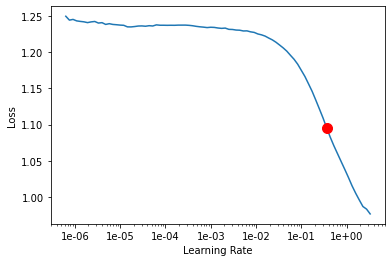

In [18]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

min_grad_lr = learner.recorder.min_grad_lr
lr = min_grad_lr

Train the model using fit_one_cycle in two steps using gradual unfreezing:
- For the first step, the weights of the LSTM layers are kept frozen and the rest of the model is trained. 
- In the second step, all layers are unfrozen so that the LSTM layers can be fine-tuned

Number of epochs and learning rate are the two hyperparameters that can be tuned here

In [19]:
random_seed(1234, True)

learner.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.313257,0.301208,0.878335,1.351491,02:57


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.313257,0.301208,0.878335,1.351491,02:57
1,0.343261,0.304754,0.880799,1.356292,02:57
2,0.316596,0.292862,0.883916,1.340258,02:57
3,0.307156,0.284933,0.886353,1.329674,02:57
4,0.310972,0.282592,0.886931,1.326563,02:57


In [23]:
random_seed(1234, True)

learner.unfreeze()
learner.fit_one_cycle(6, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.199291,0.192138,0.913167,1.211837,04:02
1,0.207451,0.193034,0.913417,1.212924,04:02
2,0.203030,0.191308,0.913674,1.210832,04:02
3,0.199602,0.190630,0.913951,1.210012,04:02
4,0.195923,0.188678,0.914056,1.207651,04:02
5,0.195792,0.188345,0.914147,1.207250,04:02


Save the model

In [24]:
learner.save(f'{name}_finetuned')

# Save the encoder
learner.save_encoder(f'{name}_finetuned_enc')

## Target task regressor fine-tuning on target task LM

Train-validation-test splits
- Split the data into train-validation-test sets
- Validation set is used for hyperparameter tuning
- Test set is used for the final performance evaluation

In [25]:
random_seed(1234, True)

train_ , test = train_test_split(data, test_size=0.20, random_state=100)
train, valid = train_test_split(train_, test_size=0.125, random_state=0)
print(train.shape)
print(test.shape)
print(valid.shape)

(2891, 2)
(827, 2)
(414, 2)


# SMILES augmentation for regression task

- For the regression task, a gaussian noise (with mean zero and standard deviation, σg_noise) is added to the labels of the augmented SMILES during the training 
- The number of augmented SMILES and σg_noise is tuned on the validation set

In [26]:
def ee_smiles_augmentation(df, N_rounds, noise):
    '''
    noise: add gaussion noise to the label
    '''
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['yield'].append(df.iloc[i]['yield'] + np.random.normal(0,noise))
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [27]:
random_seed(1234, True)

train_aug = ee_smiles_augmentation(train, 75, noise=0.8)
print("Train_aug: ", train_aug.shape)

Train_aug:  (219716, 2)


## Data pre-processing

Create a text databunch for regression:

- It takes as input the train and validation data
- Pass the vocab of the fine-tuned LM
- Specify the column containing text data and output 
- Define the batch size according to the GPU memory available

In [28]:
random_seed(1234, True)

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

data_db = TextClasDataBunch.from_df(path, train, valid, bs=bs, tokenizer=tok, chunksize=50000, text_cols='smiles',label_cols='yield', vocab=lm_data.vocab, max_vocab=60000, include_bos=False, min_freq=1, num_workers=0)

print(f'Vocab Size: {len(data_db.vocab.itos)}')

Vocab Size: 32


If the TextClasDataBunch doesn't recognize the output of regression as FloatList and identifies it as CategoryList, we can define our custom databunch as follows

In [29]:
'''random_seed(1234, True)

tok_new = TokenizeProcessor(tokenizer=tok, chunksize=50000, include_bos=False)
num_new = NumericalizeProcessor(vocab=lm_data.vocab, max_vocab=60000, min_freq=1) 

data_db = (TextList.from_df(df, path, cols='smiles', processor=[tok_new, num_new])
.split_from_df(col='valid')
.label_from_df(cols='yield', label_cls=FloatList)
.databunch(bs=bs))'''

"random_seed(1234, True)\n\ntok_new = TokenizeProcessor(tokenizer=tok, chunksize=50000, include_bos=False)\nnum_new = NumericalizeProcessor(vocab=lm_data.vocab, max_vocab=60000, min_freq=1) \n\ndata_db = (TextList.from_df(df, path, cols='smiles', processor=[tok_new, num_new])\n.split_from_df(col='valid')\n.label_from_df(cols='yield', label_cls=FloatList)\n.databunch(bs=bs))"

### Training the regression model

Create a learner for regression:
- Pass the databunch
- Load the encoder of the fine-tuned LM
- The drop_mult hyperparameter can be tuned
- The model is evaluated using RMSE and R-squared value as error metric

In [30]:
random_seed(1234, True)

reg_learner = text_classifier_learner(data_db, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [rmse,r2_score])
reg_learner.load_encoder(f'{name}_finetuned_enc')
reg_learner.freeze()

The regressor is fine-tuned using gradual unfreezing method in four steps: 
- the regressor 
- the regressor and the final LSTM layer 
- the regressor and the last two LSTM layers, and 
- the full model

Number of epochs and learning rate in each of these steps are tuned

In [31]:
random_seed(1234, True)

reg_learner.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,1291.614990,1195.263184,34.463402,-0.721980,00:03
1,799.982117,771.235046,27.702942,-0.111163,00:03
2,631.249329,468.209076,21.580299,0.322298,00:03
3,543.494934,429.933716,20.677279,0.378901,00:03
4,483.322266,390.699585,19.644081,0.437814,00:03


In [32]:
random_seed(1234, True)

reg_learner.freeze_to(-2)
reg_learner.fit_one_cycle(6, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,395.387939,485.193909,21.648975,0.311988,00:04
1,422.651306,436.590424,20.550444,0.378280,00:04
2,415.884766,427.563873,20.624548,0.379736,00:04
3,408.084106,398.645294,19.752449,0.429389,00:04
4,396.283722,380.718811,19.309637,0.454980,00:04
5,384.557709,376.387817,19.197081,0.460850,00:04


In [33]:
random_seed(1234, True)

reg_learner.freeze_to(-3)
reg_learner.fit_one_cycle(6, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,362.440857,381.425415,19.348463,0.452302,00:06
1,374.555908,376.099670,19.215324,0.459286,00:06
2,368.914581,362.330414,18.929781,0.476545,00:06
3,366.265564,362.648468,18.901133,0.477997,00:06
4,362.085999,366.220978,18.946060,0.474597,00:06
5,357.685120,364.734558,18.903852,0.476711,00:06


In [34]:
random_seed(1234, True)

reg_learner.unfreeze()
reg_learner.fit_one_cycle(6, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,348.669983,366.872955,18.990320,0.472051,00:08
1,361.074036,366.742401,18.976612,0.472723,00:08
2,339.196289,258.892273,16.008657,0.626677,00:08
3,285.994385,164.581421,12.788906,0.760670,00:08
4,240.117920,139.927475,11.772836,0.796530,00:08
5,205.662552,133.767975,11.510179,0.804962,00:08


The regressor can also be fine-tuned all at once without any frozen weights (i.e., no gradual unfreezing)

In [35]:
random_seed(1234, True)

reg_learner.unfreeze()
reg_learner.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,150.122314,133.906464,11.520778,0.804436,00:08
1,157.080917,125.635994,11.154183,0.816693,00:08
2,150.362457,128.473633,11.316560,0.812031,00:08
3,148.318893,113.831261,10.637506,0.833477,00:08
4,147.135437,122.702393,10.998269,0.823161,00:08
5,141.818314,129.576187,11.363327,0.810655,00:08
6,139.372375,101.064842,10.029490,0.852900,00:08
7,135.924744,101.984612,10.076980,0.850850,00:08
8,132.356827,90.126526,9.460682,0.869291,00:08
9,129.732224,94.796555,9.706110,0.862231,00:08


Save the model

In [36]:
split_id = 12
reg_learner.save(f'{split_id}_reg_finetuned')

### Evaluation on the Test Set

Test time SMILES augmentation

In [37]:
def test_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['yield'].append(df.iloc[i]['yield'])
    df_aug = pd.DataFrame.from_dict(dist_aug)
    
    return pd.DataFrame.from_dict(dist_aug)


The test set performance is evaluated using the predictions based on the canonical SMILES as well as that employing test-time augmentation

In [38]:
preds = []

# Randomized SMILES Predictions
for i in range(4):
    np.random.seed(12*i)
    test_aug = test_smiles_augmentation(test,1)
    
    #model
    test_db = TextClasDataBunch.from_df(path, train, test_aug, tokenizer=tok, vocab=lm_data.vocab, text_cols='smiles', label_cols='yield', bs=bs, include_bos=False)
    learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [r2_score, rmse])
    learner.load(f'{split_id}_reg_finetuned'); 
  
    #get predictions
    pred,lbl = learner.get_preds(ordered=True)
    
    preds.append(pred)

# Canonical SMILES Predictions
test_db = TextClasDataBunch.from_df(path, train, test, bs=bs, tokenizer=tok, chunksize=50000, text_cols='smiles',label_cols='yield', vocab=lm_data.vocab, max_vocab=60000, include_bos=False)

learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [r2_score, rmse])
learner.load(f'{split_id}_reg_finetuned');


#get predictions
pred_canonical,lbl = learner.get_preds(ordered=True)
    
#preds.append(pred_canonical)

In [39]:
preds.append(pred_canonical)

In [40]:
print('Test Set (Canonical)')
print('RMSE:', root_mean_squared_error(pred_canonical,lbl))
print('R2:', r2_score(pred_canonical,lbl))
print('MAE:', mean_absolute_error(pred_canonical,lbl))

avg_preds = sum(preds)/len(preds)
print('\n')
print('Test Set (Average)')
print('RMSE:', root_mean_squared_error(avg_preds,lbl))
print('R2:', r2_score(avg_preds,lbl))
print('MAE:', mean_absolute_error(avg_preds,lbl))

Test Set (Canonical)
RMSE: tensor(9.1349)
R2: tensor(0.8885)
MAE: tensor(6.5022)


Test Set (Average)
RMSE: tensor(968.2802)
R2: tensor(-1251.2449)
MAE: tensor(195.5471)
